## Running a VQE Simulation for H2 using pennylane qchem tools.

Import all necessary pennylane packages, as well as our user-defined run_vqe function, which serves to shorten the notebook & make the code cleaner.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
from run_vqe import *

import pennylane as qml
import numpy as np

Use pennylane's qchem tools to generate our hamiltonian from the h2.xyz file. 

In [2]:
name = 'h2'
geometry = 'h2.xyz'
charge = 0
multiplicity = 1
basis_set = 'sto-3g'

hamiltonian, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis_set,
    n_active_electrons=2,
    n_active_orbitals=2,
    mapping='jordan_wigner'
)

/anaconda2/envs/py37/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/anaconda2/envs/py37/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


Define our device and ansatz

In [3]:
dev = qml.device("default.qubit", wires=4)


def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Create our cost function using pennylane's VQECost function, and initialize all our constants for the upcoming optimization.

In [4]:
cost = qml.VQECost(ansatz, hamiltonian, dev)

init_params = np.random.uniform(low=0, high=2*np.pi, size=12)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

In [5]:
print(init_params)

[6.16828138 3.32277067 5.51539484 0.64483205 0.08497558 5.05467899
 0.23961822 0.8396981  1.52781316 1.73926654 0.97624871 4.81202693]


Run both VQE runs using our user-defined run_vqe function, which takes the arguments cost_fn, max_iterations, inital_params, type of optimizer, and optimization step size. To understand more about how this condensation works check out run_vqe.py located in this folder.

In [11]:
vanilla_run, vanilla_n = run_vqe(cost_fn=cost, 
                      max_iter=max_iterations, 
                      initial_params=init_params, 
                      opt_name='GradientDescentOptimizer', 
                      step_size=step_size)

Iteration = 0,  Energy = -0.29539266 Ha,  Convergence parameter = 0.05328693 Ha
Iteration = 20,  Energy = -0.96063151 Ha,  Convergence parameter = 0.03788994 Ha
Iteration = 40,  Energy = -1.11703202 Ha,  Convergence parameter = 0.00013639 Ha
Iteration = 60,  Energy = -1.11742722 Ha,  Convergence parameter = 0.00000300 Ha
Iteration = 80,  Energy = -1.11751073 Ha,  Convergence parameter = 0.00000570 Ha
Iteration = 100,  Energy = -1.11767957 Ha,  Convergence parameter = 0.00001156 Ha
Iteration = 120,  Energy = -1.11801862 Ha,  Convergence parameter = 0.00002301 Ha
Iteration = 140,  Energy = -1.11868127 Ha,  Convergence parameter = 0.00004422 Ha
Iteration = 160,  Energy = -1.11991028 Ha,  Convergence parameter = 0.00007942 Ha
Iteration = 180,  Energy = -1.12198174 Ha,  Convergence parameter = 0.00012638 Ha
Iteration = 200,  Energy = -1.12496343 Ha,  Convergence parameter = 0.00016605 Ha
Iteration = 220,  Energy = -1.12839723 Ha,  Convergence parameter = 0.00016955 Ha
Iteration = 240,  Ener

In [9]:
qng_run, qng_n = run_vqe(cost_fn=cost, 
                  max_iter=max_iterations, 
                  initial_params=init_params, 
                  opt_name='QNGOptimizer', 
                  step_size=step_size, 
                  diag_approx=False, lam=0.001)

Iteration = 0,  Energy = -0.44366386 Ha,  Convergence parameter = 0.20155814 Ha

Final value of the energy = -1.13618891
Number of iterations =  19


All that's left is to plot the results! As expected, the QNG out-perfomed the vanilla gradient descent optimization method. 

In [14]:
exact_value = -1.136189454088

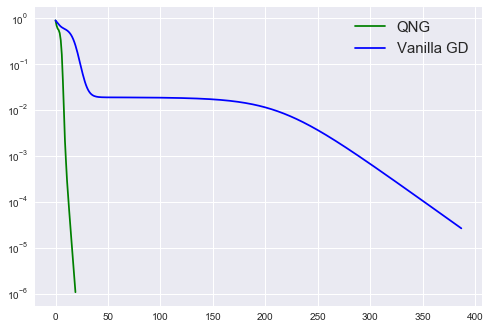

In [17]:
ax = plt.axes()

plt.style.use("seaborn")
plt.plot(np.array(qng_run)-exact_value, color='g', label='QNG')
plt.plot(np.array(vanilla_run)-exact_value, color='b', label='Vanilla GD')
# ax.axhline(y = -1.136189454088, label='exact groundstate', color='red')

plt.yscale('log')

plt.legend(fontsize=15)
plt.show()